# Regression Pipeline!

In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
# Import stratifiedKFold
from sklearn.model_selection import KFold

In [136]:
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
def scale_data(data):
    data = data.copy()
    scaler = StandardScaler()
    for col in data.columns:
        if is_numeric_dtype(data[col]):
            data[col] = scaler.fit_transform(data[[col]])
    return data

In [137]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9, 12.0]
c = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
d = [object, object, object, object, object, object, object, object, object, object]
data = {'a': a, 'b': b, 'c': c, 'd': d}
df = pd.DataFrame(data)
df = scale_data(df)
df

,a,b,c,d
0,-1.57,-1.52,a,<class 'object'>
1,-1.22,-1.19,b,<class 'object'>
2,-0.87,-0.86,c,<class 'object'>
3,-0.52,-0.53,d,<class 'object'>
4,-0.17,-0.20,e,<class 'object'>
5,0.17,0.14,f,<class 'object'>
6,0.52,0.47,g,<class 'object'>
7,0.87,0.80,h,<class 'object'>
8,1.22,1.13,i,<class 'object'>
9,1.57,1.76,j,<class 'object'>


In [138]:
def cross_validate_model(model, X, y):
    cv_strat = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X, y, cv=cv_strat, scoring=['neg_root_mean_squared_error'], return_train_score=True, return_estimator=True)
    return cv_results

In [139]:
def average_cv_results(cv_results):
    avg_results = {}
    print(cv_results.keys())
    for key in cv_results.keys():
        if key == 'estimator':
            continue
        avg_results[key] = cv_results[key].mean()
    # Get best estimator according to RMSE
    best_estimator_index = cv_results['test_neg_root_mean_squared_error'].argmax()
    best_estimator = cv_results['estimator'][best_estimator_index]
    return avg_results, best_estimator

In [140]:
def lazy_model(df, target, drop_cols=[]):
    from lazypredict.supervised import LazyRegressor
    X = df.drop(columns=[target] + drop_cols)
    X = X.drop(columns=X.select_dtypes('datetimetz').columns)
    print(X.info())
    y = df[target]
    X = scale_data(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    return models

In [141]:
def feature_importance(model, X, y):
    model.fit(X, y)
    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    elif hasattr(model, 'coef_'):
        feature_importances = pd.DataFrame(model.coef_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    else:
        print('Model does not have feature importances')
    return feature_importances

In [142]:
def average_feature_importance(models, X, y):
    feature_importances = []
    for model in models:
        feature_importances.append(feature_importance(model, X, y))
    avg_importances = pd.concat(feature_importances).groupby(level=0).mean().sort_values('importance', ascending=False)
    return avg_importances[:10]


In [143]:
def lime_regression(model, X_train, X_test, y_train, y_test):
    import lime
    import lime.lime_tabular
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='regression', training_labels=y_train.values, feature_names=X_train.columns)

    exp = explainer.explain_instance(X_test.values[0], model.predict, num_features=len(X_train.columns))
    return exp

In [144]:
def shap_values(model, X):
    import shap
    shap.initjs()
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    return shap_values

In [145]:
# Load the data from pkl
cf = pd.read_pickle('../../data/processed/train_no_outliers.pkl')
# get object columns
object_cols = cf.select_dtypes(include='object').columns
object_cols

Index(['lote', 'lote_parental_cf', 'id_bio', 'id_centr', 'id_bio_ino',
       'orden'],
      dtype='object')

In [146]:
# Drop row which have null in 'cantidad_of'
cf = cf.dropna(subset=['cantidad_of'])

# Target is producto_1_cf
y = cf['producto_1_cf']
# Features are all columns except producto_1_cf
X = cf.drop(columns=['producto_1_cf'])
# Drop all columns which are not numeric
#X = X.select_dtypes(include=['number'])
drop_cols = ['producto_2_cf','lote', 'lote_parental_cf','id_bio', 'id_bio_ino', 'id_centr', 'orden']
# Save _mc columns to mc_columns
mc_columns = X.filter(like='_mc').columns
# Drop columns
X = X.drop(columns=mc_columns)

X = X.drop(columns=drop_cols)
# If a column is datetime drop it
import numpy as np
X = X.drop(columns=X.select_dtypes('datetimetz').columns)
X.shape, y.shape

((151, 142), (151,))

In [147]:
# Find NATType
X.dtypes.value_counts()
# find object columns
object_cols = X.select_dtypes(include='object').columns
object_cols

Index([], dtype='object')

In [148]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 0 to 151
Columns: 142 entries, orden_encadenado_cf to h_cent_th_cf
dtypes: float64(141), int64(1)
memory usage: 168.7 KB


In [149]:
def grid_search_random_forest(X, y):
    from sklearn.model_selection import GridSearchCV
    rf = RandomForestRegressor()
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [10, 20, 30, 35],
        'min_samples_split': [2, 5, 8, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'random_state': [42]
    }
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    return grid_search

In [150]:
# Perform cross validation
# Scale
X = scale_data(X)

# Grid search
#grid_search = grid_search_random_forest(X, y)
#print(grid_search.best_params_)

In [151]:
def impute_data(df):
    df = df.copy()
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].median())
    return df

In [152]:
# Perform cross validation
# Scale

X = scale_data(X)

#model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=4, n_estimators=100, random_state=42)
#from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, AdaBoostRegressor
#model = HistGradientBoostingRegressor(random_state=42)
#model = GradientBoostingRegressor(random_state=42)
#model = AdaBoostRegressor(random_state=42)
model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=59)
# neural network
cv_results = cross_validate_model(model, X, y)
avg_results, best_estimator = average_cv_results(cv_results)
print('test average RMSE:', avg_results['test_neg_root_mean_squared_error'])
print('train average RMSE:', avg_results['train_neg_root_mean_squared_error'])
print('best_estimator test RMSE:', cv_results['test_neg_root_mean_squared_error'].max())
print(feature_importance(best_estimator, X, y))
print(average_feature_importance(cv_results['estimator'], X, y))


dict_keys(['fit_time', 'score_time', 'estimator', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error'])
test average RMSE: -260.5272850616745
train average RMSE: -107.38039285777813
best_estimator test RMSE: -194.3640128782834
                          importance
turbidez_diff_cf                0.05
turb_fin_cultivo_cf             0.04
pres_par_O2_1_bt_min_cf         0.03
pres_par_O2_1_bt_cf             0.03
h_bio_th_cf                     0.03
...                              ...
sol_base_bt_min_cf              0.00
caudal_ct_min_cf                0.00
desc_parcial_ct_last_cf         0.00
desc_total_ct_first_cf          0.00
desc_parcial_ct_first_cf        0.00

[142 rows x 1 columns]
                          importance
turbidez_diff_cf                0.05
turb_fin_cultivo_cf             0.04
pres_par_O2_1_bt_min_cf         0.03
pres_par_O2_1_bt_cf             0.03
h_bio_th_cf                     0.03
presion_agua_ct_min_cf          0.02
total_sol_base_bt_max_cf  

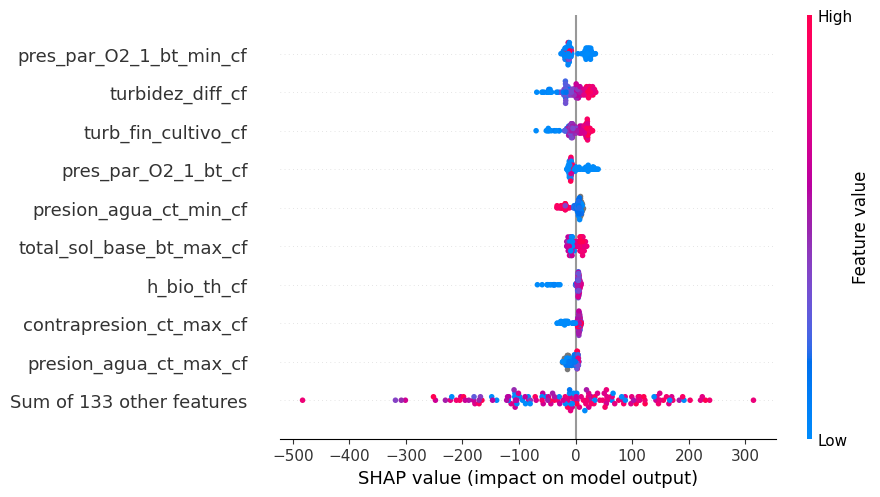

In [153]:
# shap
import shap
exp = shap_values(best_estimator, X)
shap.plots.beeswarm(exp)

In [154]:
# Get interaction values
#shap_interaction_values = shap.TreeExplainer(best_estimator).shap_interaction_values(X)
#shap.summary_plot(shap_interaction_values, X)


In [155]:
# load test
cf_test = pd.read_pickle('../../data/processed/test_mc_ino_pino_of.pkl')
cf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Columns: 169 entries, lote to h_cent_th_cf
dtypes: datetime64[ns, UTC](6), float64(142), int64(2), object(19)
memory usage: 74.1+ KB


In [156]:
cf_test = cf_test.sort_values('lote', ascending=True).reset_index(drop=True)
# Save lote
lotes = cf_test['lote']
# Drop columns
drop_cols = ['producto_2_cf','lote', 'lote_parental_cf','id_bio' , 'id_centr']
cf_test = cf_test.drop(columns=drop_cols)
# Drop product_1_cf
cf_test = cf_test.drop(columns=['producto_1_cf'])
# Drop datetime columns
cf_test = cf_test.drop(columns=cf_test.select_dtypes('datetimetz').columns)

cf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Columns: 157 entries, orden_encadenado_cf to h_cent_th_cf
dtypes: float64(140), int64(2), object(15)
memory usage: 68.8+ KB


In [157]:
# Train a model with all data
model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=8, n_estimators=50, random_state=42)
X = scale_data(X)
#X = X[features.index]
model.fit(X, y)


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=8,
                      n_estimators=50, random_state=42)

In [158]:
# Scale
cf_test = scale_data(cf_test)
# Drop columns
cf_test = cf_test[X.columns]
# Predict
y_pred = model.predict(cf_test)

# Save predictions
predictions = pd.DataFrame({'lote': lotes, 'producto_1_cf': y_pred})
# Order by lote
predictions = predictions.sort_values('lote', ascending=True).reset_index(drop=True)
# Sep | without header
predictions.to_csv('../../data/processed/universityhack.predict', sep='|', header=False, index=False)